In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [2]:
df = pd.read_csv("data/StudentsPerformance.csv")
df.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
# Create total score
df["total_score"] = (
    df["math score"] +
    df["reading score"] +
    df["writing score"]
)

# Top 30% performers
threshold = df["total_score"].quantile(0.7)
df["performance"] = (df["total_score"] >= threshold).astype(int)

df[["total_score", "performance"]].head()


,total_score,performance
0,218,0
1,247,1
2,278,1
3,148,0
4,229,1


In [4]:
X = df.drop(
    ["math score", "reading score", "writing score", "total_score", "performance"],
    axis=1
)

y = df["performance"]

# One-hot encoding
X = pd.get_dummies(X, drop_first=True)

X.head()


,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_standard,test preparation course_none
0,False,True,False,False,False,True,False,False,False,False,True,True
1,False,False,True,False,False,False,False,False,True,False,True,False
2,False,True,False,False,False,False,False,True,False,False,True,True
3,True,False,False,False,False,False,False,False,False,False,False,True
4,True,False,True,False,False,False,False,False,True,False,True,True


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(C=0.5, max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)


In [7]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=5,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


In [8]:
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)


In [9]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_gb)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_gb)
    ],
    "Recall": [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_gb)
    ],
    "F1-score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_gb)
    ]
})

results


,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.704,0.52381,0.289474,0.372881
1,Random Forest,0.692,0.47619,0.131579,0.206186
2,Gradient Boosting,0.712,0.55000,0.289474,0.379310


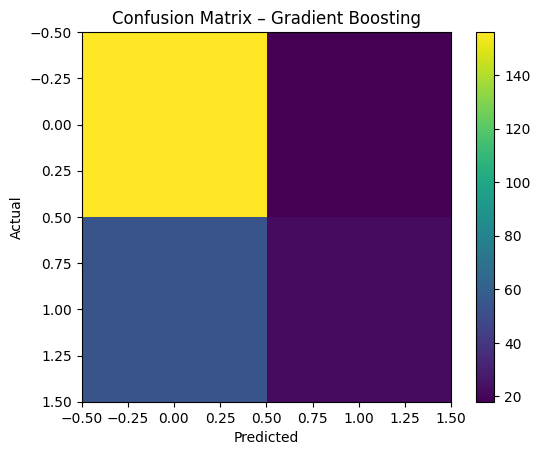

In [10]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_gb)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix – Gradient Boosting")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [11]:
importances = rf.feature_importances_
features = X.columns

fi = pd.Series(importances, index=features).sort_values(ascending=False)
fi.head(10)


test preparation course_none                     0.202382
lunch_standard                                   0.199010
race/ethnicity_group E                           0.142239
parental level of education_high school          0.107218
gender_male                                      0.087383
parental level of education_master's degree      0.040935
parental level of education_some college         0.040654
race/ethnicity_group C                           0.040218
race/ethnicity_group D                           0.037566
parental level of education_bachelor's degree    0.035711
dtype: float64

In [12]:
# This project avoids data leakage by excluding score-based features.
# Student performance is defined using a quantile-based threshold (top 30%).
